# How did total number of weekly active students change over the semester¶

In [5]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as ticker
import sys
sys.path.insert(0, '/home/jenny/remote_learning_code_Spring_2017-2020')
from utils import parse_args


sys.argv = ['-f']
args = parse_args()

term_20 = args.semester_2020_Spring
start_date_20 = args.start_date_2020_Spring
remote_date_20 = args.remote_date_2020_Spring
end_date_20 = args.end_date_2020_Spring

# load student by race
f = open('/home/jenny/remote_learning_code_Spring_2017-2020/user_racial_groups.pkl', 'rb')
stu_race = pickle.load(f)
races = list(stu_race.keys())
print(stu_race.keys())

# load students
f = open('/home/jenny/remote_learning_code_Spring_2017-2020/user_id_groups.pkl', 'rb')
user = pickle.load(f)
students = user['student']

dict_keys(['Asian', 'International', 'Pacific Islander', 'African American', 'Decline to State', 'Native American/Alaskan Native', 'White', 'Chicano/Latino'])


In [7]:


# Student events include submitting assignment, commenting on submission, creating discussion topic, creating discussion entries.

# load submission
submission = pd.read_csv(args.submissions, sep='\t', header=0)
submission = submission.loc[submission['user_id'].isin(students)]
submission = submission.loc[(submission['created_at'].notnull())&(submission['created_at']>=start_date_20)&(submission['created_at']<=end_date_20), ['user_id', 'assignment_id', 'created_at','submitted_at']] # no duplicate exists
submission = submission.loc[(submission['submitted_at'].notnull())&(submission['submitted_at']>=start_date_20)&(submission['submitted_at']<=end_date_20)]

# loading submission comments
comments = pd.read_csv(args.submission_comments, sep='\t', header=0)
comments = comments.loc[comments['author_id'].isin(students)]

# loading discussions
announce = pd.read_csv(args.discussion_topics, sep='\t', header=0)
announce = announce.loc[announce['user_id'].isin(students)]
announce = announce.loc[(announce['created_at']>=start_date_20)&(announce['created_at']<=end_date_20)]

# loading discussion entries
discussion = pd.read_csv(args.discussion_entry, sep='\t', header=0)
discussion = discussion.loc[discussion['user_id'].isin(students)]
discussion = discussion.loc[(discussion['created_at']>=start_date_20)&(discussion['created_at']<=end_date_20)]

[6921, 11617, 4077, 4566, 1019, 130, 52]


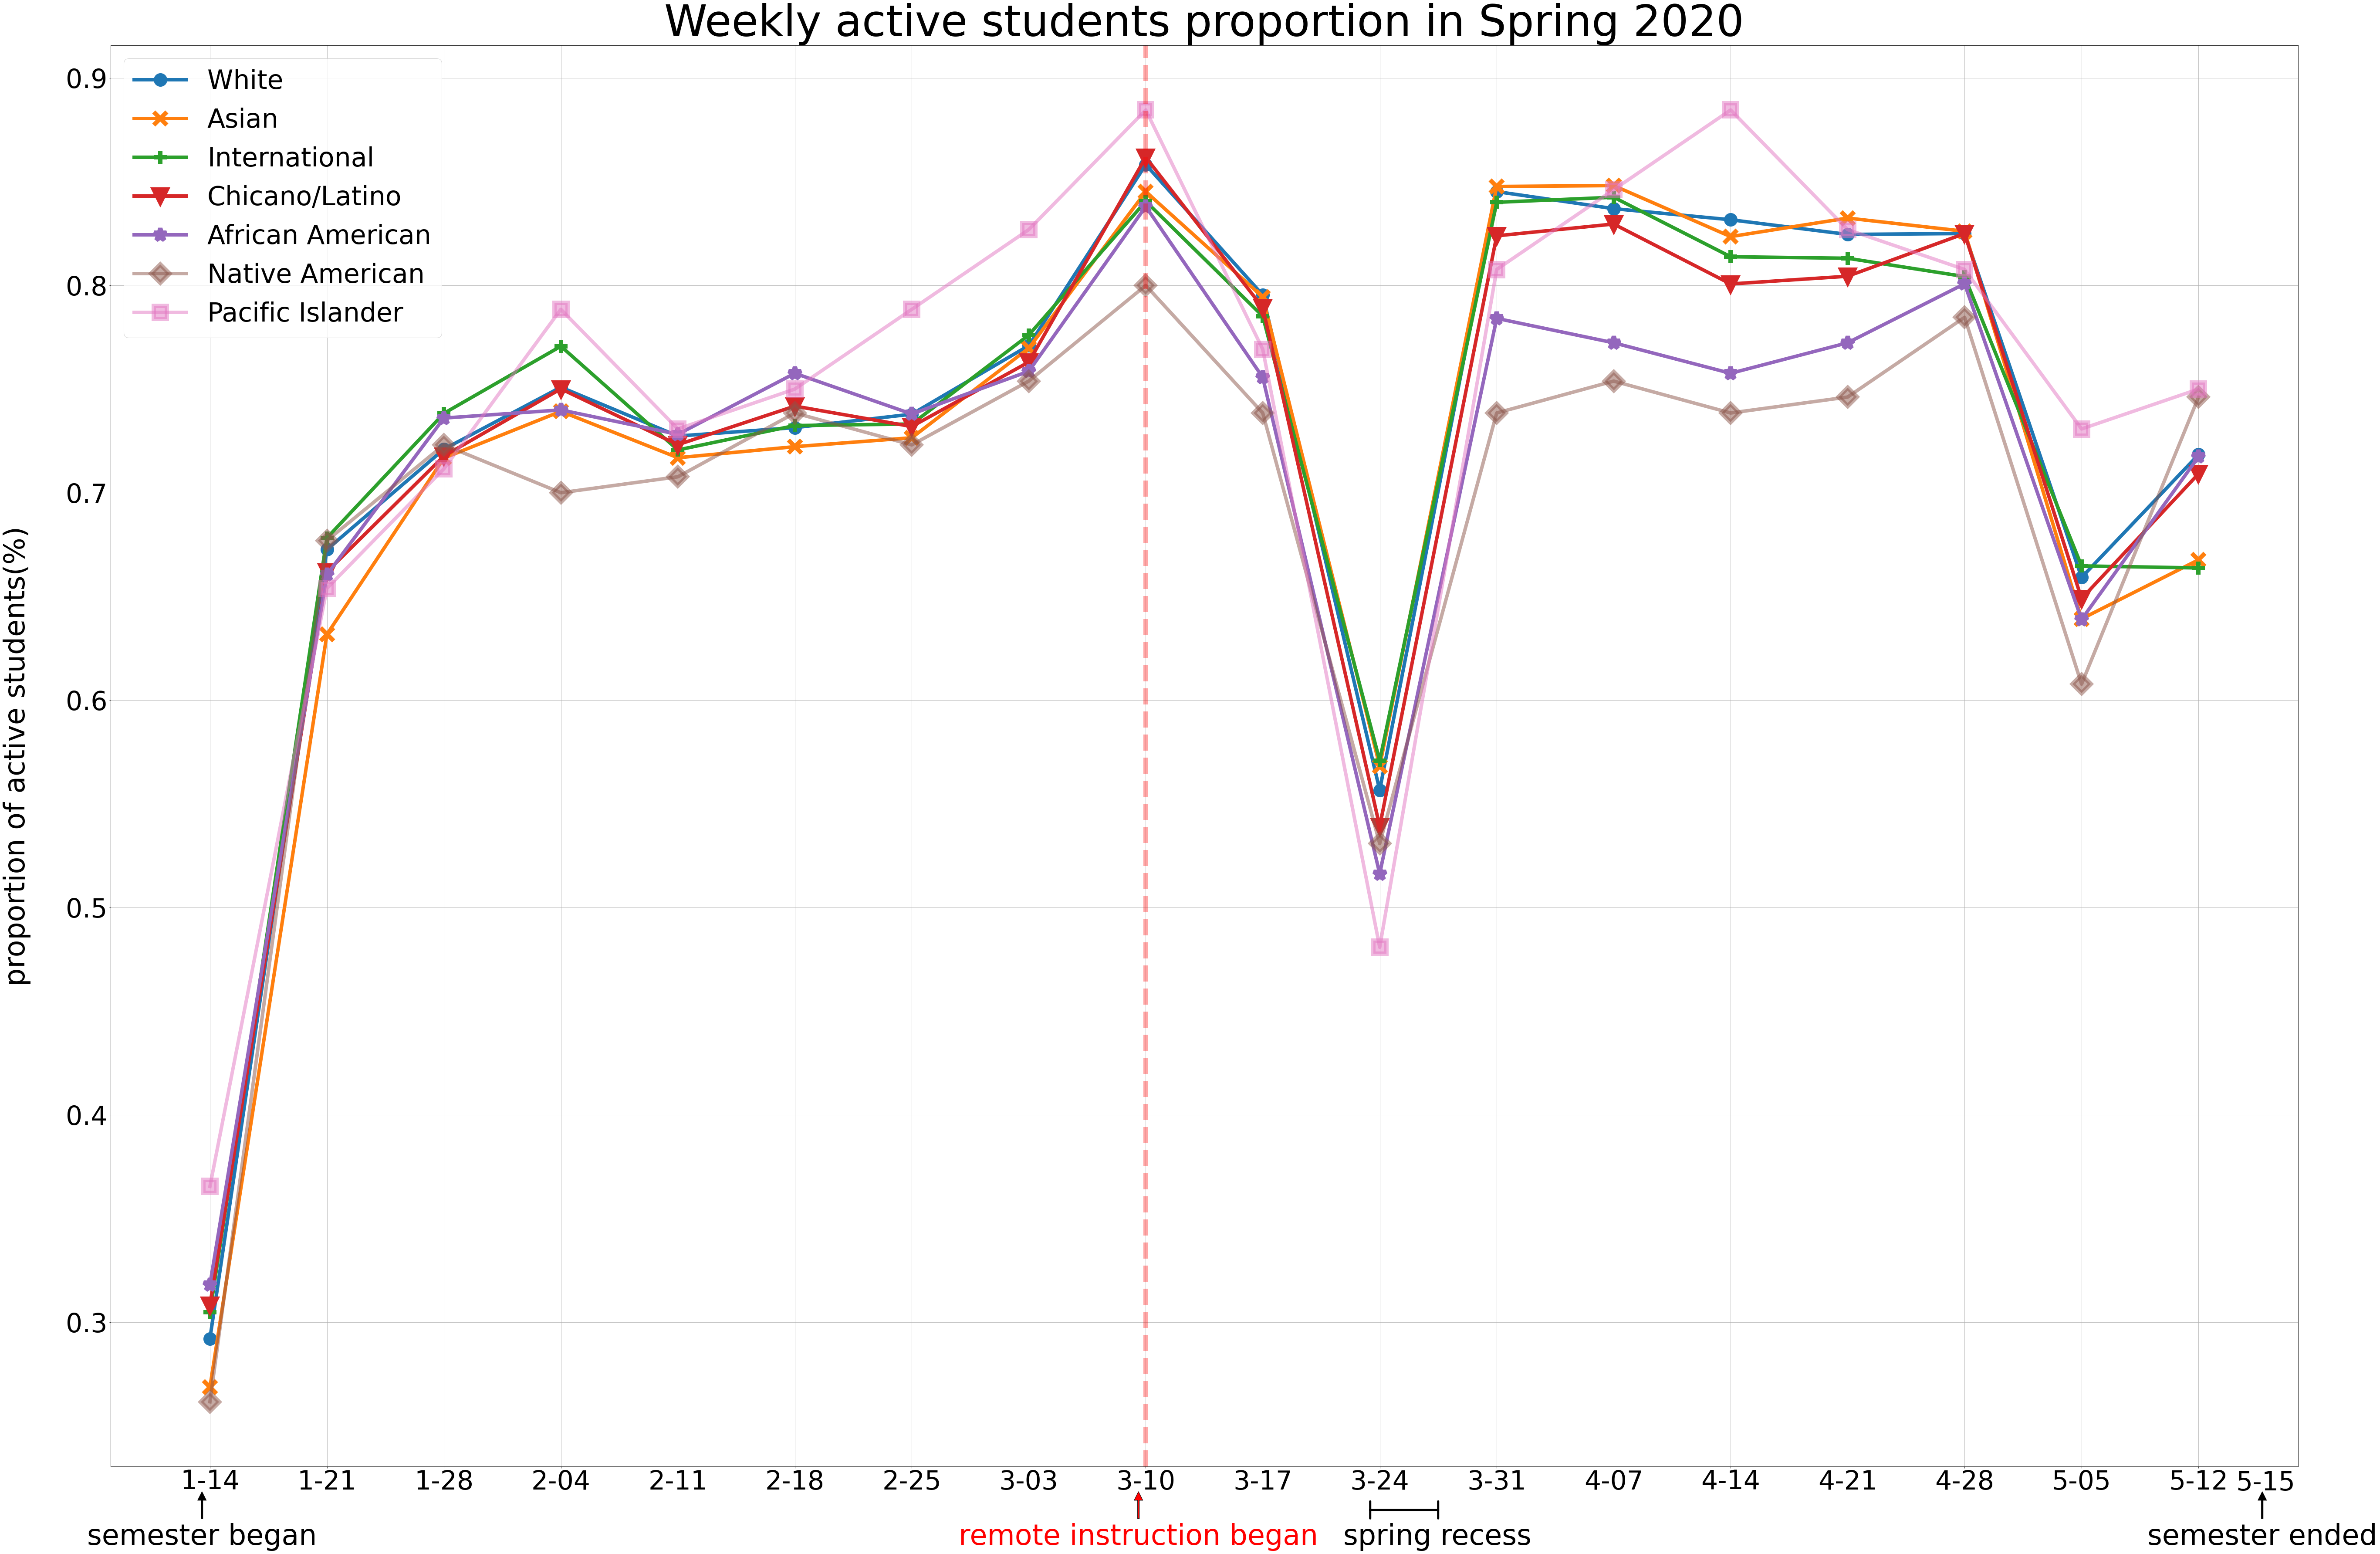

In [8]:
# plot all races together
african = stu_race['African American']
asian = stu_race['Asian']
chicano = stu_race['Chicano/Latino']
inter = stu_race['International']
native = stu_race['Native American/Alaskan Native']
pacific = stu_race['Pacific Islander']
white = stu_race['White']
users = [white, asian, inter, chicano, african, native, pacific]


submission_create = submission.loc[:, ['user_id', 'created_at']]
submission_create.columns = ['user_id', 'time']
submission_submit = submission.loc[:, ['user_id', 'submitted_at']]
submission_submit.columns = ['user_id', 'time']
comments = comments.loc[(comments['message_size_bytes']>0)&(comments['created_at']>=start_date_20)&(comments['created_at']<=end_date_20), ['author_id', 'submission_id', 'assignment_id', 'created_at', 'message_size_bytes']]
comments1 = comments.loc[:, ['author_id', 'created_at']]
comments1.columns = ['user_id', 'time']
announce1 = announce.loc[(announce['workflow_state']=='active'), ['user_id', 'created_at']]
announce1.columns = ['user_id', 'time']
discussion1 = discussion.loc[(discussion['workflow_state']=='active'), ['user_id', 'created_at']]
discussion1.columns = ['user_id', 'time']
user_time = pd.concat((submission_create, submission_submit, comments1, announce1, discussion1), axis=0)
# transfer day to week
user_time['time'] = pd.to_datetime(user_time['time'], format='%Y-%m-%d %H:%M:%S.%f')
user_time['time'] = user_time['time'].apply(lambda x: x.date())
user_time['time'] = user_time['time'].apply(lambda x: x.isocalendar()[1])
min_week = min(user_time['time'].tolist())
user_time['time'] = user_time['time'] - min_week+1

active_user_num = []
all_users = user_time['user_id'].drop_duplicates()
for i in range(len(users)):
    active_user_num.append(len(set(all_users).intersection(set(users[i]))))
    
print(active_user_num)

user_time_group = user_time.groupby('time')
user_actions_num = [[],[],[],[],[],[],[]]
for i in user_time_group.groups.keys():
    group = user_time_group.get_group(i) # week
    for j in range(len(users)):
        race_actions = group.loc[group['user_id'].isin(users[j])]
        num_users = len(race_actions['user_id'].drop_duplicates())
        user_actions_num[j].append([i, num_users/active_user_num[j]])
for i in range(len(user_actions_num)):
    user_actions_num[i] = sorted(user_actions_num[i], key=lambda x: x[0])

user_actions_num = np.array(user_actions_num)
user_actions_num = user_actions_num[:, :, 1]
date = ['1-14', '1-21', '1-28', '2-04', '2-11', '2-18', '2-25', '3-03', '3-10', '3-17', '3-24', '3-31', '4-07', '4-14', '4-21', '4-28', '5-05', '5-12']

fig,ax = plt.subplots()
fig.patch.set_facecolor('white')
# set x-axis ticks
#myFmt = mdates.DateFormatter('%m-%d')
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
#ax.set_xlim([datetime.date(2020, 1, 10), datetime.date(2020, 5, 18)])

plt.plot(date, user_actions_num[0], scalex=True, scaley=True, data=None, marker='o', markersize=30, linewidth=8, label='White')
plt.plot(date, user_actions_num[1], scalex=True, scaley=True, data=None, marker='x', markersize=30, markeredgewidth=10, linewidth=8, label='Asian')
plt.plot(date, user_actions_num[2], scalex=True, scaley=True, data=None, marker='+', markersize=30, markeredgewidth=10, linewidth=8, label='International')
plt.plot(date, user_actions_num[3], scalex=True, scaley=True, data=None, marker='v', markersize=30, markeredgewidth=10, linewidth=8, label='Chicano/Latino')
plt.plot(date, user_actions_num[4], scalex=True, scaley=True, data=None, marker='*', markersize=30, markeredgewidth=10, linewidth=8, label='African American')
plt.plot(date, user_actions_num[5], scalex=True, scaley=True, data=None, marker='D', markersize=30, markeredgewidth=10, linewidth=8, label='Native American', alpha=0.5)
plt.plot(date, user_actions_num[6], scalex=True, scaley=True, data=None, marker='s', markersize=30, markeredgewidth=10, linewidth=8, label='Pacific Islander', alpha=0.5)

plt.legend(fontsize=60)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Weekly active students proportion in Spring 2020', fontsize=100)
#plt.xlabel('week', fontsize=65, labelpad=140)
plt.ylabel('proportion of active students(%)', fontsize=65, labelpad=80)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(210, -50), xytext=(210, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2360, -50), xytext=(2360, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4940, -50), xytext=(4940, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2890, -100), xytext=(3050, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2830, -180), xycoords='axes points')
plt.axvline(x='3-10', color = 'r', linewidth=10, alpha=0.35, linestyle='--')

plt.show()
